# League of Legends tier estimation
- Correlation analysis
- Softmax Regression
- XGB Classifier

## 0. Import Packages

In [389]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# pip install seaborn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

from xgboost import XGBClassifier
from xgboost import plot_importance 
from matplotlib import pyplot
from sklearn.metrics import accuracy_score

print(tf.__version__)

2.3.0


## 1. Load dataset

In [222]:
csv = pd.read_csv('lol_dataset.csv', encoding = 'cp949')

In [223]:
csv.head()

,id,time,tier,KDA,DPS,ward,cs,cspm
0,1,31분 58초,Challenger,6/5/11,31367,0/10/5,296,9.3
1,2,31분 58초,Challenger,9/6/13,24054,7/11/8,141,4.4
2,3,31분 58초,Challenger,9/1/7,18880,2/10/15,377,11.8
3,4,24분 1초,Challenger,14/4/13,25399,8/16/1,108,4.5
4,5,24분 1초,Challenger,6/3/8,18421,4/7/4,194,8.1


## 2. Make Variables

In [250]:
DPS = csv['DPS']
cs = csv['cs']
cspm1 = csv['cspm']
cspm = cspm1.astype(float)

DPS = np.array(DPS)
cs = np.array(cs)
cspm = np.array(cspm)

In [251]:
dps = []
for mod in DPS:
    
    item_mod = mod.replace(",", "")
    dps.append(int(item_mod))

In [252]:
DPS = dps
DPS = np.array(DPS)

### 2-1) time

In [25]:
time_orig = csv['time']
time_orig = np.array(time_orig)
time_orig[:5]
# time_orig.shape

array(['31분 58초', '31분 58초', '31분 58초', '24분 1초', '24분 1초'], dtype=object)

In [85]:
time_minute = []
for i in range(len(time_orig)):
    mod = time_orig[i].split('분')
    time_minute.append(int(mod[0]))
        
print(time_minute)        

[31, 31, 31, 24, 24, 24, 24, 24, 28, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 27, 27, 22, 22, 22, 22, 22, 22, 22, 22, 25, 25, 25, 25, 25, 15, 15, 15, 15, 15, 15, 15, 15, 15, 21, 21, 21, 21, 35, 43, 43, 43, 43, 43, 43, 19, 19, 19, 19, 19, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 32, 32, 17, 17, 17, 17, 17, 17, 17, 22, 22, 22, 22, 22, 22, 22, 15, 15, 15, 15, 15, 15, 15, 30, 30, 30, 30, 30, 30, 30, 31, 37, 30, 25, 26, 37, 24, 16, 21, 37, 41, 34, 16, 16, 27, 27, 27, 27, 27, 37, 37, 37, 37, 25, 25, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 23, 23, 23, 23, 39, 39, 39, 39, 39, 39, 39, 39, 22, 22, 22, 22, 17, 17, 17, 17, 27, 27, 27, 27, 27, 27, 27, 27, 22, 22, 22, 22, 22, 22, 22, 22, 32, 32, 32, 32, 15, 15, 15, 15, 31, 31, 31, 31, 26, 26, 26, 26, 24, 24, 24, 24, 24, 24, 24, 24, 30, 30, 30, 30, 23, 23, 23, 23, 31, 31, 31, 31, 27, 27, 27, 27, 23, 23, 23, 23, 23, 23, 23, 23, 35, 35, 35, 35, 35, 35,

### 2-2) KDA

In [54]:
KDA_orig = csv['KDA']

In [59]:
KDA_K = []
KDA_D = []
KDA_A = []
for i in range(len(KDA_orig)):
    mod = KDA_orig[i].split('/')
#     print(i)
    KDA_K.append(int(mod[0]))
    KDA_D.append(int(mod[1]))
    KDA_A.append(int(mod[2]))
    
    
KDA_K = np.array(KDA_K)
KDA_D = np.array(KDA_D)
KDA_A = np.array(KDA_A)

In [124]:
KDA_cal = []
for i in range(len(KDA_orig)):
    if KDA_D[i] == 0:
        KDA_D[i] = 1  ## inf 방지
    else :
        KDA_cal.append(int((KDA_K[i]+KDA_A[i])/KDA_D[i]))

In [126]:
KDA_cal = np.array(KDA_cal)
np.shape(KDA_cal)

(300,)

### 2-3) Ward

In [78]:
ward_orig = csv['ward']

In [80]:
ward1 = []
ward2 = []
ward3 = []
for i in range(len(ward_orig)):
    mod = ward_orig[i].split('/')
    ward1.append(int(mod[0]))
    ward2.append(int(mod[1]))
    ward3.append(int(mod[2]))
#     print(i)
    
ward1 = np.array(ward1)
ward2 = np.array(ward2)
ward3 = np.array(ward3)

In [81]:
ward_sum = ward1 + ward2 + ward3

### 2-4) DPS per minute

In [114]:
DPS_pt = DPS/time_minute

### 2-5) tier

In [86]:
tier_uni=csv['tier'].unique()
tier_uni
['Iron 4', 'Iron 3', 'Iron 2','Iron 1','Bronze 4','Bronze 3','Bronze 2','Bronze 1','Silver 4','Silver 3','Silver 2','Silver 1',
 'Gold 4','Gold 3','Gold 2','Gold 1','Platinum 4','Platinum 3','Platinum 2','Platinum 1','Diamond 4','Diamond 3','Diamond 2',
 'Diamond 1','Master','Grandmaster','Challenger']

['Iron 4',
 'Iron 3',
 'Iron 2',
 'Iron 1',
 'Bronze 4',
 'Bronze 3',
 'Bronze 2',
 'Bronze 1',
 'Silver 4',
 'Silver 3',
 'Silver 2',
 'Silver 1',
 'Gold 4',
 'Gold 3',
 'Gold 2',
 'Gold 1',
 'Platinum 4',
 'Platinum 3',
 'Platinum 2',
 'Platinum 1',
 'Diamond 4',
 'Diamond 3',
 'Diamond 2',
 'Diamond 1',
 'Master',
 'Grandmaster',
 'Challenger']

In [91]:
tier = csv['tier']
tier_num = []
for a in range(len(csv)):
    for b in range(len(tier_uni)):
        if (tier[a] == tier_uni[b]):
            tier_num.append(b+1)

- independent variables : DPS, cs, cspm, time_minute, KDA_K, KDA_D, KDA_A, KDA_cal, ward1, ward2, ward3, ward_sum
- dependent variables : tier

In [123]:
np.shape(KDA_cal)

(288,)

In [225]:
df = pd.DataFrame({'DPS':DPS,'cs':cs,'cspm':cspm,'time_minute':time_minute,'KDA_K':KDA_K,'KDA_D':KDA_D,'KDA_A':KDA_A,
                  'KDA_cal':KDA_cal,'ward1':ward1,'ward2':ward2,'ward3':ward3,'ward_sum':ward_sum, 
                   'DPS_pt':DPS_pt, 'tier_num':tier_num})
df

,DPS,cs,cspm,time_minute,KDA_K,KDA_D,KDA_A,KDA_cal,ward1,ward2,ward3,ward_sum,DPS_pt,tier_num
0,31367,296,9.3,31,6,5,11,3,0,10,5,15,1011.838710,9
1,24054,141,4.4,31,9,6,13,3,7,11,8,26,775.935484,9
2,18880,377,11.8,31,9,1,7,16,2,10,15,27,609.032258,9
3,25399,108,4.5,24,14,4,13,6,8,16,1,25,1058.291667,9
4,18421,194,8.1,24,6,3,8,4,4,7,4,15,767.541667,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,54,11,0.8,14,0,1,0,0,0,0,0,0,3.857143,1
296,133,13,0.9,14,0,1,0,0,0,1,0,1,9.500000,1
297,4205,110,7.8,14,1,1,4,5,0,4,0,4,300.357143,1
298,14039,103,4.2,24,5,8,3,1,0,4,0,4,584.958333,1


## 3. Correlation Analysis

In [226]:
df.describe()

,cs,cspm,time_minute,KDA_K,KDA_D,KDA_A,KDA_cal,ward1,ward2,ward3,ward_sum,DPS_pt,tier_num
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,167.090000,6.345000,26.003333,6.100000,4.966667,6.786667,3.776667,2.453333,7.756667,3.133333,13.343333,640.364574,5.313333
std,57.090041,1.584311,7.004298,4.399377,3.061066,4.850386,4.577112,2.530316,4.104503,3.464423,8.013291,585.919719,2.363707
min,11.000000,0.800000,14.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.761905,1.000000
25%,124.000000,5.375000,22.000000,3.000000,2.000000,3.000000,1.000000,0.000000,5.000000,1.000000,7.750000,424.676471,3.000000
50%,165.000000,6.400000,25.000000,5.000000,5.000000,6.000000,2.000000,2.000000,7.000000,2.000000,12.000000,575.171212,5.000000
75%,201.000000,7.500000,31.000000,9.000000,7.000000,9.000000,5.000000,4.000000,10.000000,4.000000,17.250000,769.555195,7.000000
max,395.000000,11.800000,43.000000,23.000000,22.000000,27.000000,29.000000,15.000000,26.000000,19.000000,47.000000,9607.411765,9.000000


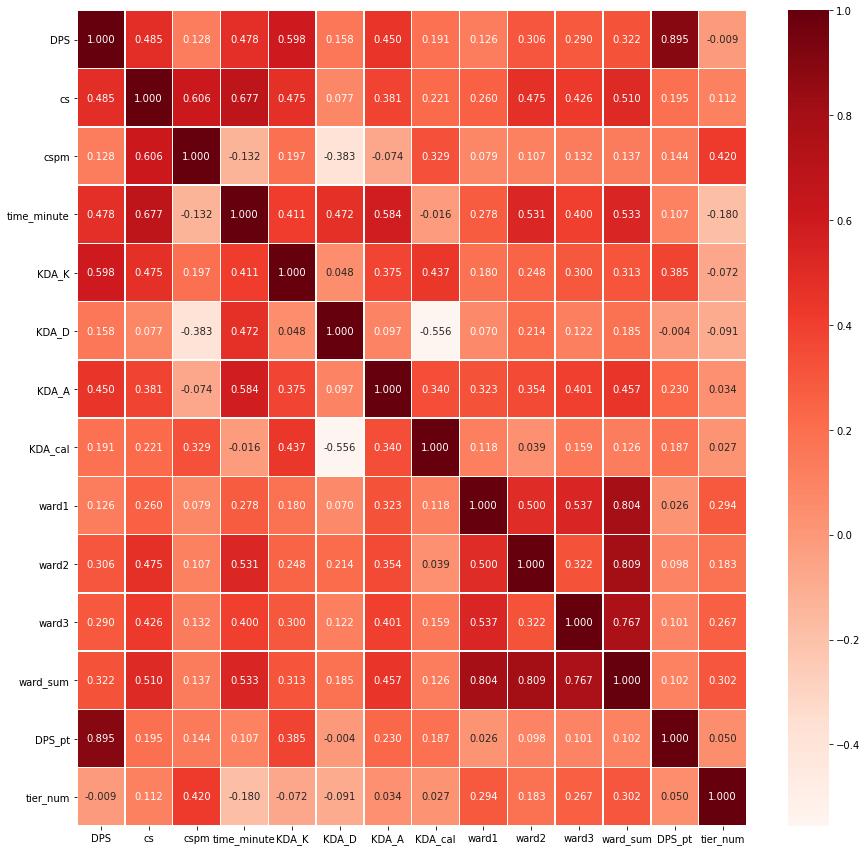

In [283]:
plt.figure(figsize=(15,15))
sns.heatmap(data = df.corr(), annot=True, 
fmt = '.3f', linewidths=.5, cmap='Reds')

plt.savefig('correlation analysis.jpg')
plt.show()

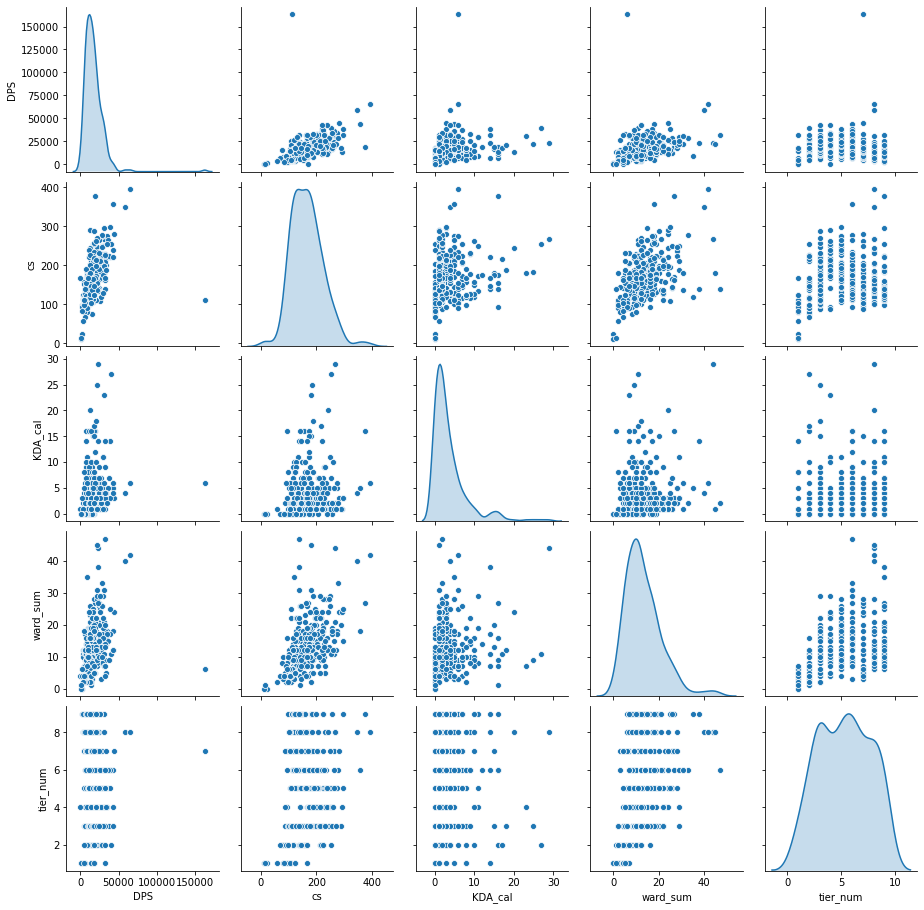

In [284]:
sns.pairplot(df[["DPS", "cs", "KDA_cal", "ward_sum", "tier_num"]], diag_kind="kde")
plt.savefig("pairplot.jpg")

plt.show()

- regression X -> classification

## 4. Make dataset

In [403]:
tier_no=csv['tier']
tier_name=[]
for i in range(len(tier_no)):
    tier=tier_no[i].split(' ')
    tier_name.append(tier[0])
    
tier_uni=csv['tier'].unique()
tier_uni=['Iron','Bronze','Silver','Gold','Platinum','Diamond','Master','Grandmaster','Challenger']

tier = csv['tier']
tier_num = []
for a in range(len(csv)):
    for b in range(len(tier_uni)):
        if (tier_name[a] == tier_uni[b]):
            tier_num.append(b)
len(tier_num)

300

In [404]:
df = pd.DataFrame({'DPS':DPS,'cs':cs,'cspm':cspm,'time_minute':time_minute,'KDA_K':KDA_K,'KDA_D':KDA_D,'KDA_A':KDA_A,
                  'KDA_cal':KDA_cal,'ward1':ward1,'ward2':ward2,'ward3':ward3,'ward_sum':ward_sum, 
                   'DPS_pt':DPS_pt, 'tier_num':tier_num})
df

,DPS,cs,cspm,time_minute,KDA_K,KDA_D,KDA_A,KDA_cal,ward1,ward2,ward3,ward_sum,DPS_pt,tier_num
0,31367,296,9.3,31,6,5,11,3,0,10,5,15,1011.838710,8
1,24054,141,4.4,31,9,6,13,3,7,11,8,26,775.935484,8
2,18880,377,11.8,31,9,1,7,16,2,10,15,27,609.032258,8
3,25399,108,4.5,24,14,4,13,6,8,16,1,25,1058.291667,8
4,18421,194,8.1,24,6,3,8,4,4,7,4,15,767.541667,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,54,11,0.8,14,0,1,0,0,0,0,0,0,3.857143,0
296,133,13,0.9,14,0,1,0,0,0,1,0,1,9.500000,0
297,4205,110,7.8,14,1,1,4,5,0,4,0,4,300.357143,0
298,14039,103,4.2,24,5,8,3,1,0,4,0,4,584.958333,0


In [405]:
# split train and test

train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [406]:
print(np.shape(train_dataset))
print(np.shape(test_dataset))

(240, 14)
(60, 14)


In [407]:
train_stats = train_dataset.describe()
train_stats.pop("tier_num")
train_stats = train_stats.transpose()
train_stats

test_stats = test_dataset.describe()
test_stats.pop("tier_num")
test_stats = test_stats.transpose()
test_stats

np.shape(test_stats)

(13, 8)

In [408]:
train_labels = train_dataset.pop('tier_num')
test_labels = test_dataset.pop('tier_num')

In [409]:
normed_train_data =(train_dataset - train_stats['mean']) / train_stats['std']
normed_test_data = (test_dataset - test_stats['mean']) / test_stats['std']

In [410]:
normed_train_data

,DPS,cs,cspm,time_minute,KDA_K,KDA_D,KDA_A,KDA_cal,ward1,ward2,ward3,ward_sum,DPS_pt
208,1.614467,1.513372,1.948201,0.011367,3.230507,-1.272104,-0.126666,5.169211,-0.587790,0.306584,-0.604384,-0.268785,1.346767
188,-0.491609,-0.663707,-0.455907,-0.562950,-1.194845,1.331776,-1.174937,-0.856421,-0.587790,0.071504,-0.013540,-0.144011,-0.268457
12,-0.803602,-0.629150,1.085188,-1.424426,-0.973578,-0.946619,-0.965283,-0.410078,-0.587790,-0.398657,-0.308962,-0.518335,-0.404141
221,0.008583,0.856793,0.468750,0.585684,0.796563,-1.272104,0.082988,2.937496,0.660614,-0.633737,-0.308962,-0.268785,-0.112010
239,0.962172,0.217492,0.715325,-0.419371,1.239099,-1.272104,0.921605,4.276525,-1.003925,-0.398657,-0.604384,-0.767884,1.049281
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,-0.631267,-0.698263,0.900257,-1.424426,-0.088507,-0.621134,-1.174937,-0.410078,-0.171656,-0.398657,-0.604384,-0.518335,-0.174043
119,1.234138,1.858940,0.592037,1.590739,2.124169,-0.295649,-0.545974,0.259437,-0.171656,0.541664,0.872726,0.604637,0.424291
102,1.126138,0.891350,0.530394,0.585684,1.239099,0.029836,2.179530,0.259437,-1.003925,-0.398657,-0.013540,-0.518335,0.683797
35,-0.780386,-0.611871,1.270119,-1.568005,-1.194845,-0.295649,-1.384591,-0.856421,-0.171656,-0.163577,-0.899806,-0.518335,-0.330188


In [411]:
len(train_dataset.keys())

13

## 5. Softmax Classification

In [414]:
model =keras. models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape = [None, 13]))
# model.add(Dropout(0.5))
# model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(9, activation = 'softmax'))

model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [415]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, None, 64)          896       
_________________________________________________________________
dense_56 (Dense)             (None, None, 9)           585       
Total params: 1,481
Trainable params: 1,481
Non-trainable params: 0
_________________________________________________________________


In [416]:
batch_size = 1
epochs = 100

In [417]:
hist = model.fit(normed_train_data, train_labels,epochs=epochs)

Epoch 1/100
8/8 [==============================] - 0s 874us/step - loss: 2.3000 - accuracy: 0.0667
Epoch 2/100
8/8 [==============================] - 0s 1ms/step - loss: 2.2321 - accuracy: 0.1000
Epoch 3/100
8/8 [==============================] - 0s 1ms/step - loss: 2.1839 - accuracy: 0.1208
Epoch 4/100
8/8 [==============================] - 0s 748us/step - loss: 2.1400 - accuracy: 0.1750
Epoch 5/100
8/8 [==============================] - 0s 1ms/step - loss: 2.1017 - accuracy: 0.2083
Epoch 6/100
8/8 [==============================] - 0s 1ms/step - loss: 2.0684 - accuracy: 0.2208
Epoch 7/100
8/8 [==============================] - 0s 997us/step - loss: 2.0389 - accuracy: 0.2292
Epoch 8/100
8/8 [==============================] - 0s 997us/step - loss: 2.0130 - accuracy: 0.2333
Epoch 9/100
8/8 [==============================] - 0s 748us/step - loss: 1.9879 - accuracy: 0.2417
Epoch 10/100
8/8 [==============================] - 0s 998us/step - loss: 1.9646 - accuracy: 0.2333
Epoch 11/100
8/8 

In [418]:
train_score = model.evaluate(normed_train_data, train_labels, verbose=0)
test_score = model.evaluate(normed_test_data, test_labels, verbose=0)

print('Train accuracy:', train_score[1])
print('Test accuracy:', test_score[1])

Train accuracy: 0.5458333492279053
Test accuracy: 0.21666666865348816


## 6. XGB Classifier

In [419]:
model1 = XGBClassifier() 
model1.fit(normed_train_data, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

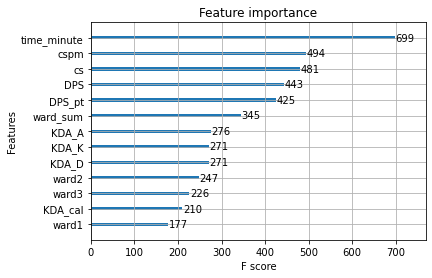

In [420]:
plot_importance(model1) 
plt.savefig("XGB Feature importance.jpg")
plt.show()

In [421]:
train_pred = model1.predict(normed_train_data)
test_pred = model1.predict(normed_test_data)

train_acc = accuracy_score(train_pred, train_labels)
test_acc = accuracy_score(test_pred, test_labels)
print("Train Accuracy: %.2f%%" % (train_acc * 100.0))
print("Test Accuracy: %.2f%%" % (test_acc * 100.0))

Train Accuracy: 100.00%
Test Accuracy: 31.67%
